## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xgb

import plotly.express as px

pd.set_option('display.max_columns', 100)

renderer=None 
renderer="png"  # Turn this on so it is visible in Github

## Reading data

In [2]:
# building permits = bp
bp = pd.read_parquet('data/planning_df.parquet')

## Question to be explored

### 1) what does it cost to build an apartment?  
Currently we say:  
base_cost_to_build_an_apartment = 420000 * 1.30 (developer profit)  
demolition_costs = 120000 (Probably a bit high but we wanted to include a bigger $ for value of existing dwelling) 

We could just replace that with the average cost for 2023 in the data, or if we think construction is more expensive in fancier suburbs or in smaller lots or higher buildings or w/e.... we could do a regression to predict building cost ~ building_lots/sqm + SAx (or dist from CBD or w/e) + year.

In [3]:
# Type 2 are apartments according to here: https://www.vba.vic.gov.au/building/regulatory-framework/building-classes
bp['basis_bca'].value_counts().head(15)

basis_bca
1AI      371565
10A      243250
1a(a)    234065
1A       213220
10a       91427
10B       83499
1ai       53242
10b       46263
5         40167
6         33171
1AII      24753
9B        24263
2         16337
9b        12526
7B        12105
Name: count, dtype: int64

In [4]:
# The only other strings with 2 are 6(2) and 3(2) - not apartments
bp[(bp['basis_bca'].str.contains('2')) &
   (bp['basis_bca'].notna())].value_counts('basis_bca')

basis_bca
2       16337
6(2)     1933
3(2)      101
Name: count, dtype: int64

In [5]:
# We'll save abp with just type 2 building permits
# Also focus on metro for simplicity. Only 500 of the 16,000 were Rural anyway
abp = bp[(bp['basis_bca'] == '2')
          & (bp['region'] == 'Metropolitan')
        ].copy()

abp['basis_bca'].value_counts()

basis_bca
2    15805
Name: count, dtype: int64

In [109]:
## The most simple way to answer the question is here:
abp['reported_cost_of_works'].describe().astype(int)

count        15805
mean       2900276
std        7968964
min              0
25%          50000
50%         550000
75%        2400000
max      200000000
Name: reported_cost_of_works, dtype: int64

The median value is $550k, on par with the $420k * 1.3 previously used or ignoring the developer profit, also on par with $420k base + $120k demolishment costs.

In [6]:
# This won't be useful with 2/3s of values being 0.
abp['number_of_new_dwellings'].value_counts(normalize=True, dropna=False)

number_of_new_dwellings
0.0      0.656628
1.0      0.039924
2.0      0.029484
8.0      0.013540
4.0      0.013287
           ...   
134.0    0.000063
215.0    0.000063
154.0    0.000063
118.0    0.000063
144.0    0.000063
Name: proportion, Length: 213, dtype: float64

In [7]:
# Potentially more useful with only ~30% of entries being 0.
abp['number_of_storeys'].value_counts(normalize=True, dropna=False)

number_of_storeys
0.0       0.313445
3.0       0.153686
2.0       0.108510
4.0       0.105536
1.0       0.071243
            ...   
60.0      0.000063
73.0      0.000063
70.0      0.000063
1137.0    0.000063
42.0      0.000063
Name: proportion, Length: 74, dtype: float64

In [8]:
abp_clean = abp[abp['number_of_storeys'] > 0]
abp_clean.shape

(10540, 39)

In [9]:
avg_cost_by_storey = abp_clean.groupby('number_of_storeys')['reported_cost_of_works'].agg(['mean', 'count', 'median']).reset_index()

# Avoid outliers
avg_cost_by_storey_lt50 = avg_cost_by_storey[avg_cost_by_storey['number_of_storeys'] <= 50]
avg_cost_by_storey_lt20 = avg_cost_by_storey[avg_cost_by_storey['number_of_storeys'] <= 20]
avg_cost_by_storey_lt10 = avg_cost_by_storey[avg_cost_by_storey['number_of_storeys'] <= 10]

In [12]:
def chart_scatter(df, x="number_of_storeys", y="mean", title="Cost by category",
                  labels={"mean": "Average reported cost of works"}, renderer=renderer):
    fig = px.scatter(df, x=x, y=y, title=title, labels=labels,
                    width=600, height=400)

    fig.update_layout(
        margin={'t':50,'l':80,'b':10,'r':30}
    )

    fig.show(renderer)

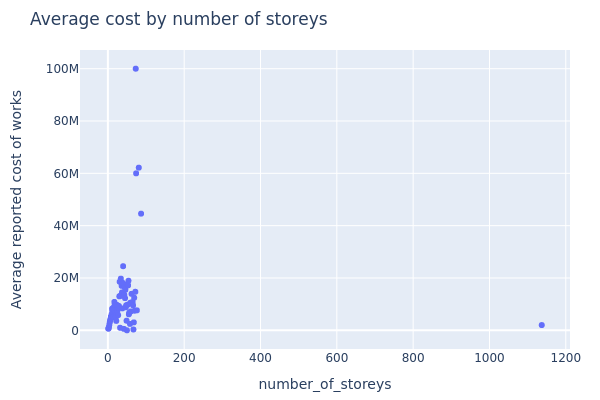

In [14]:
chart_scatter(avg_cost_by_storey, x="number_of_storeys", y="mean",
              title="Average cost by number of storeys",
              labels={"mean":"Average reported cost of works"})

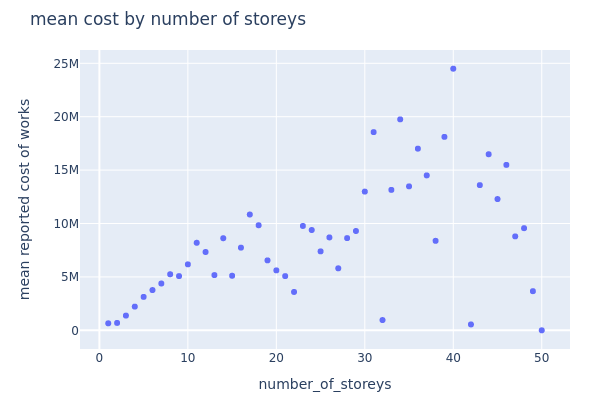

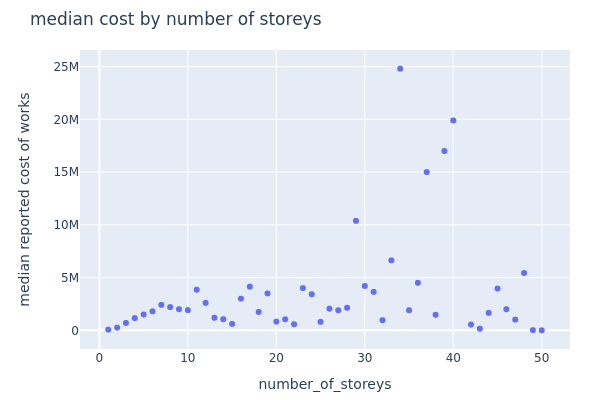

In [18]:
for i in ["mean", "median"]:
    chart_scatter(avg_cost_by_storey_lt50, x="number_of_storeys", y=i,
                title=f"{i} cost by number of storeys",
                labels={i:f"{i} reported cost of works"})

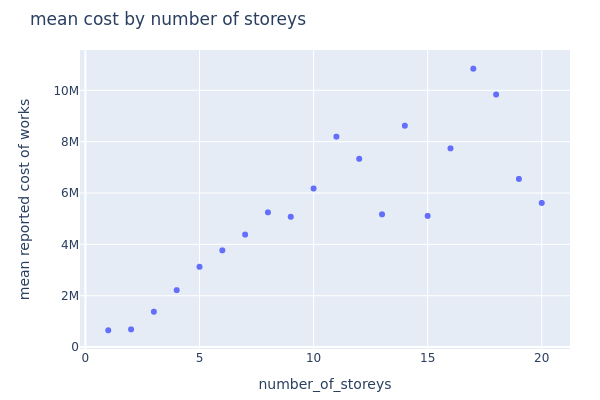

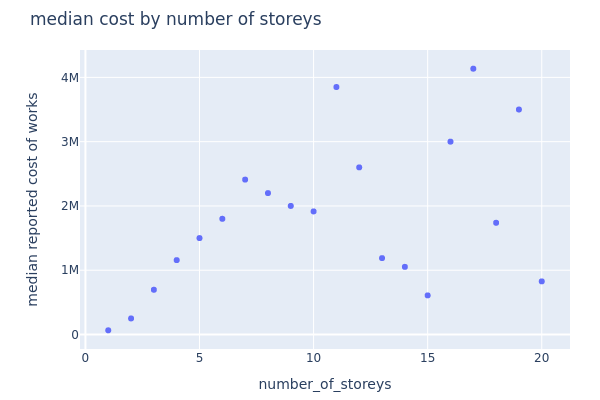

In [19]:
for i in ["mean", "median"]:
    chart_scatter(avg_cost_by_storey_lt20, x="number_of_storeys", y=i,
                title=f"{i} cost by number of storeys",
                labels={i:f"{i} reported cost of works"})

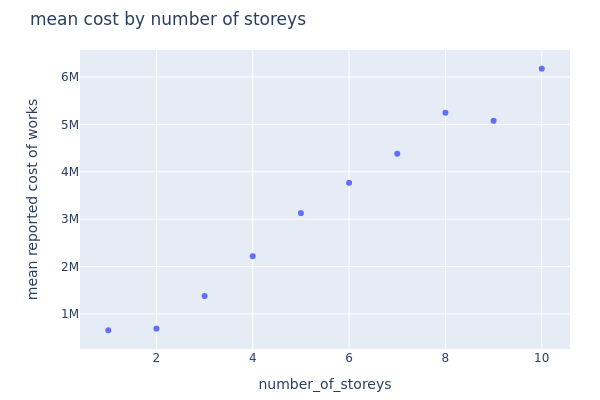

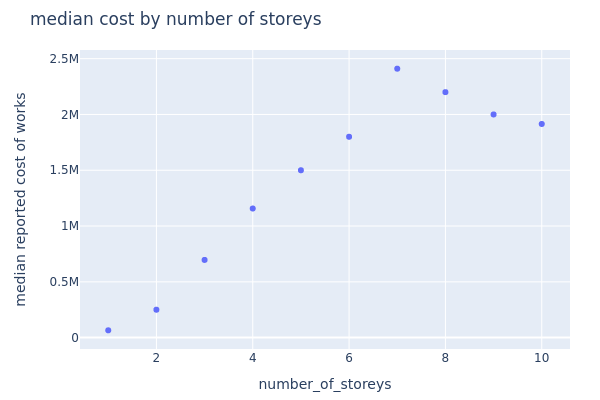

In [20]:
for i in ["mean", "median"]:
    chart_scatter(avg_cost_by_storey_lt10, x="number_of_storeys", y=i,
                title=f"{i} cost by number of storeys",
                labels={i:f"{i} reported cost of works"})

### Comparing categories

In [21]:
abp_top_councils_list = abp.value_counts('site_municipality').index[:20]

abp_top_councils = abp[abp['site_municipality'].isin(abp_top_councils_list)]
abp_top_councils

,permit_stage_number,permit_date,basis_month_y,basis_month_m,reported_levy_amount,calculated_levy_amount,reported_cost_of_works,site_street_name,site_town_suburb,site_postcode,site_municipality,municipal_full_name,region,sub_region,sub_region1,allotment_area,builder_town_suburb,builder_state,builder_postcode,floor_material,frame_material,roof_cladding_material,external_wall_material,number_of_existing_dwellings,number_of_new_dwellings,number_of_storeys,number_of_dwellings_demolished,total_floor_area,building_permit_application_date,dbdrv_amount,solar_hot_water_indicator,rainwater_tank_indicator,total_estimated_cost_of_works,basis_building_use,basis_now,basis_bca,basis_ownership_sector,basis_owner_builder,original_levy_paid
105684,0.0,2007-10-20,2010.0,11.0,24.64,24.64,19250,MARNE STREET,SOUTH YARRA,None,Melbourne,"Melbourne, City of",Metropolitan,Inner Melbourne,Melbourne,0.0,CHIRNSIDE PARK,VIC,None,20.0,60.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,2007-08-17,12.3200,0.0,0.0,19250.0,Residential,None,2,P,NaN,NaN
106258,1.0,2009-10-14,2010.0,4.0,1216.00,1216.00,950000,SYDNEY ROAD,BRUNSWICK,None,Merri-bek,"Merri-bek, City of",Metropolitan,Inner Melbourne,Inner North,278.0,TULLAMARINE,VIC,None,20.0,20.0,80.0,20.0,0.0,0.0,2.0,0.0,555.0,2008-05-29,608.0000,0.0,0.0,950000.0,Residential,None,2,P,NaN,NaN
106809,3.0,2009-12-09,2010.0,1.0,2235.53,2235.53,1746512,CLIFF STREET,SOUTH YARRA,None,Stonnington,"Stonnington, City of",Metropolitan,Inner Melbourne,Inner East,557.0,SOUTH MELBOURNE,VIC,None,20.0,40.0,60.0,11.0,0.0,0.0,2.0,0.0,1180.0,2009-06-27,1117.7677,0.0,0.0,0.0,Residential,None,2,P,NaN,NaN
107054,0.0,2009-12-18,2010.0,1.0,724.05,724.05,565690,SPENCER STREET,WEST MELBOURNE,None,Melbourne,"Melbourne, City of",Metropolitan,Inner Melbourne,Melbourne,0.0,ALTONA,Vic,None,40.0,40.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,2009-12-16,362.0416,0.0,0.0,565690.0,Residential,None,2,S,NaN,NaN
107058,0.0,2009-12-18,2010.0,1.0,707.80,707.80,552979,SPENCER STREET,WEST MELBOURNE,None,Melbourne,"Melbourne, City of",Metropolitan,Inner Melbourne,Melbourne,0.0,ALTONA,Vic,None,40.0,40.0,0.0,0.0,1.0,0.0,2.0,0.0,173.0,2009-12-16,353.9066,0.0,0.0,552979.0,Residential,None,2,S,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1620718,6.0,2024-02-02,2024.0,1.0,NaN,NaN,31503368,DEAN STREET,MOONEE PONDS,None,Moonee Valley,"Moonee Valley, City of",Metropolitan,Inner Melbourne,Inner West,59671.0,Abbotsford,VIC,None,20.0,20.0,60.0,12.0,0.0,0.0,13.0,0.0,5121.0,2023-12-08,20162.1600,0.0,0.0,190713460.0,Domestic,None,2,P,0.0,298651.94
1620772,0.0,2020-08-22,2024.0,1.0,NaN,NaN,3300,GLEN HUNTLY ROAD,ELWOOD,None,Port Phillip,"Port Phillip, City of",Metropolitan,Inner Melbourne,Central Bay,NaN,Montrose,VIC,None,NaN,NaN,NaN,NaN,0.0,0.0,2.0,0.0,NaN,2020-08-21,NaN,0.0,0.0,3300.0,Domestic,None,2,P,0.0,0.00
1620796,0.0,2020-02-06,2024.0,1.0,NaN,NaN,4300,KNEEN STREET,FITZROY NORTH,None,Yarra,"Yarra, City of",Metropolitan,Inner Melbourne,Yarra,NaN,Clifton Springs,VIC,None,NaN,NaN,NaN,NaN,0.0,0.0,3.0,0.0,NaN,2020-02-06,NaN,0.0,0.0,4300.0,Domestic,None,2,P,-1.0,0.00
1620805,0.0,2023-12-20,2024.0,1.0,NaN,NaN,4944,GARDEN AVENUE,EAST MELBOURNE,None,Melbourne,"Melbourne, City of",Metropolitan,Inner Melbourne,Melbourne,392.0,ROWVILLE,VIC,None,20.0,40.0,60.0,11.0,1.0,1.0,3.0,0.0,0.0,2023-10-26,NaN,0.0,0.0,4944.0,Domestic,None,2,P,0.0,0.00


In [22]:
avg_cost_by_storey = abp_top_councils.groupby(['number_of_storeys', 'site_municipality'])['reported_cost_of_works'].agg(['mean', 'count']).reset_index()

# Avoid outliers
avg_cost_by_storey = avg_cost_by_storey[avg_cost_by_storey['number_of_storeys'] <= 10]

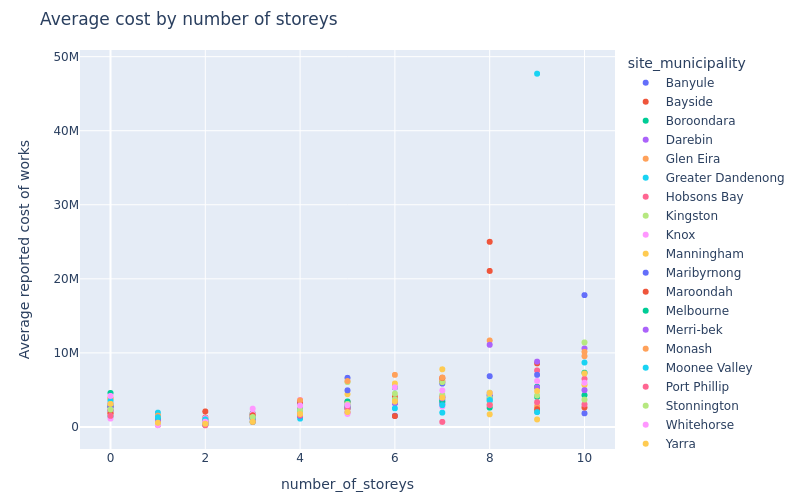

In [23]:
fig = px.scatter(avg_cost_by_storey, x="number_of_storeys", y="mean", color='site_municipality',
                 title="Average cost by number of storeys",
                 labels={"mean":"Average reported cost of works"},
                 width=800, height=500
                )

fig.update_layout(
    margin={'t':50,'l':80,'b':10,'r':30}
)

fig.show(renderer)

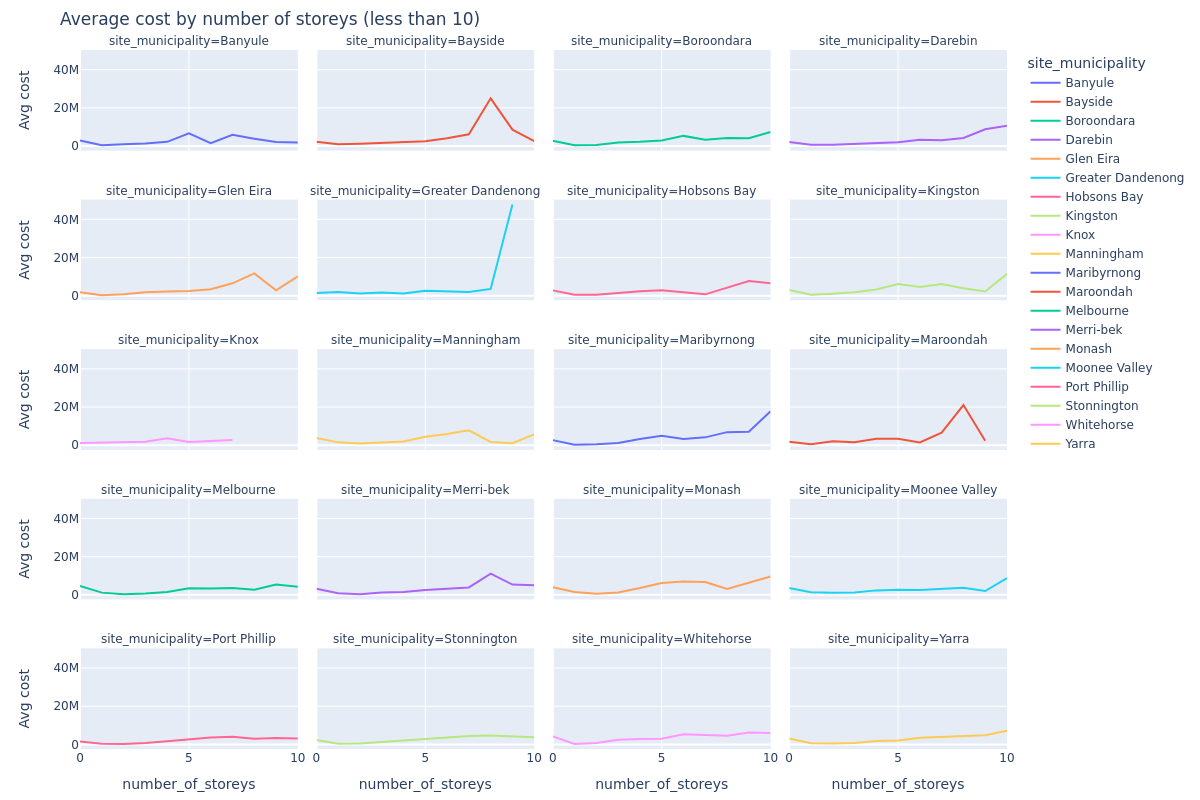

In [24]:
fig = px.line(avg_cost_by_storey, x="number_of_storeys", y="mean", color='site_municipality',
                 title="Average cost by number of storeys (less than 10)",
                 labels={"mean":"Avg cost"},
                 hover_data=avg_cost_by_storey.columns,
                 facet_col='site_municipality', facet_col_wrap=4,
                 width=1200, height=800
                )

fig.update_layout(
    margin={'t':50,'l':80,'b':10,'r':30}
)

fig.show(renderer)

In [25]:
# Want to compare years
abp_years = abp[abp['basis_month_y'] > 2018]
abp_years.basis_month_y.value_counts()

basis_month_y
2019.0    1439
2020.0     953
2023.0     441
2022.0     236
2021.0     127
2024.0      68
Name: count, dtype: int64

In [99]:
avg_cost_by_storey = abp_years.groupby(['number_of_storeys', 'basis_month_y'])['reported_cost_of_works'].agg(['mean', 'count']).reset_index()

# Avoid outliers
avg_cost_by_storey = avg_cost_by_storey[avg_cost_by_storey['number_of_storeys'] <= 20]

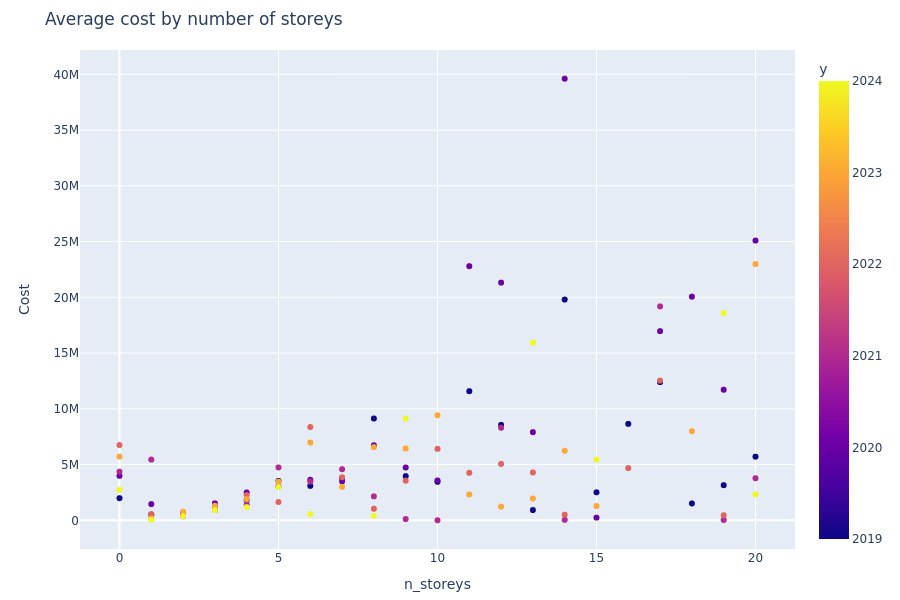

In [101]:
fig = px.scatter(avg_cost_by_storey, x="number_of_storeys", y="mean", color='basis_month_y',
                 title="Average cost by number of storeys",
                 labels={"mean":"Cost",
                         "basis_month_y": "y",
                         "number_of_storeys": "n_storeys"},
                 hover_data=avg_cost_by_storey.columns,
                 width=900, height=600
                )

fig.update_layout(
    margin={'t':50,'l':80,'b':10,'r':30},
    showlegend=False
)

fig.show(renderer)

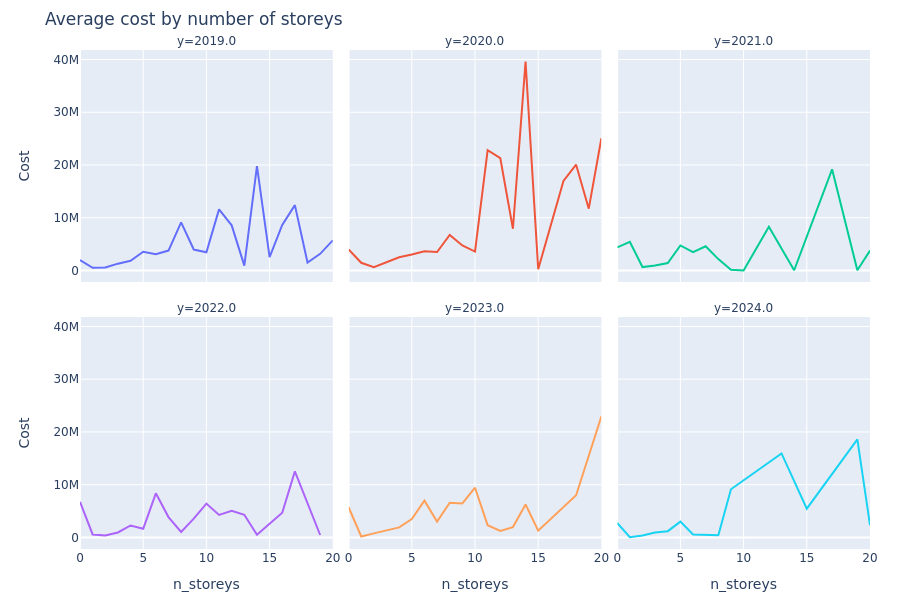

In [102]:
fig = px.line(avg_cost_by_storey, x="number_of_storeys", y="mean", color='basis_month_y',
                 title="Average cost by number of storeys",
                 labels={"mean":"Cost",
                         "basis_month_y": "y",
                         "number_of_storeys": "n_storeys"},
                 hover_data=avg_cost_by_storey.columns,
                 facet_col='basis_month_y', facet_col_wrap=3,
                 width=900, height=600
                )

fig.update_layout(
    margin={'t':50,'l':80,'b':10,'r':30},
    showlegend=False
)

fig.show(renderer)

### Seeing if any insights from non-parametric regression

In [29]:
features = ['basis_month_y', 'basis_month_m', 'site_municipality', 'allotment_area',
            'number_of_existing_dwellings', 'number_of_new_dwellings', 'number_of_storeys',
            'number_of_dwellings_demolished', 'total_floor_area']

target = 'reported_cost_of_works'

abp_model = abp[[target] + features]

abp_encoded = pd.get_dummies(abp_model, columns=['site_municipality'])

X = abp_encoded.drop(columns=target)
y = abp_encoded[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_r = xgb.XGBRegressor(objective ='reg:squarederror', 
                  n_estimators = 100, seed = 123) 

xgb_r.fit(X_train, y_train)
pred = xgb_r.predict(X_test) 

rmse = np.sqrt(mean_squared_error(y_test, pred)) 
r2 = r2_score(y_test, pred)
print(f'RMSE : {rmse}, R2 score: {r2}') 

RMSE : 9289967.45570183, R2 score: -0.0397182362824251


In [32]:
# Define the parameter grid to search
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize XGBoost regressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', seed=123)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, 
                           cv=5, n_jobs=-1, scoring='r2')

# Perform grid search
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best R2 Score:", best_score)

# Use the best parameters to train the model
best_xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', seed=123, **best_params)
best_xgb_reg.fit(X_train, y_train)

# Make predictions
pred = best_xgb_reg.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, pred)) 
r2 = r2_score(y_test, pred)
print(f'RMSE : {rmse}, R2 score: {r2}')

Best Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}
Best R2 Score: 0.1423937382971506
RMSE : 8578235.461058214, R2 score: 0.11349089188285977


11% is quite a low $R^2$ - but there are still some insights.  
Total floor area is the most 'important' (although not that important and I don't think that helpful).  
Number of storeys is also contributory to that 11%.

It's hard to logically see why basis_month_m would really help so I'd say anything below this has minimal contribution to the model.

In [36]:
feature_importance = best_xgb_reg.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

n = 10
print("Top", n, "Most Important Features:")
print(feature_importance_df.head(n))

Top 10 Most Important Features:
                         Feature  Importance
7               total_floor_area    0.257189
5              number_of_storeys    0.111836
1                  basis_month_m    0.073740
28      site_municipality_Monash    0.067061
27   site_municipality_Merri-bek    0.055813
2                 allotment_area    0.049362
4        number_of_new_dwellings    0.044455
3   number_of_existing_dwellings    0.043057
37       site_municipality_Yarra    0.042178
34  site_municipality_Whitehorse    0.039801


I don't think there is evidence from this dataset to update our current understanding of apartment cost.  

There was a good correlation between number of storeys and reported cost.


In [73]:
# Creating a dataset with num of storeys between 1-10.
abp_clean_lt21 = abp_clean[abp_clean['number_of_storeys'] < 21]

In [74]:
X = abp_clean_lt21[['number_of_storeys']]
y = abp_clean_lt21['reported_cost_of_works']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # Compute RMSE
r2 = r2_score(y_test, y_pred)

print(f'R-squared: {round(r2,3)}')

# Coefficients of the linear regression model
print('Coefficients:', int(model.coef_[0]))
print('Intercept:', int(model.intercept_))

R-squared: 0.11
Coefficients: 543473
Intercept: -4745


If there was an equation it would be something like:  
$reported\_cost = 543,473 * number\_of\_storeys - 4,745$

but this seems wrong from the outset and it is flimsy (highly variable) to price it by number of storeys.

In [76]:
# Experimenting with the preaggregated data
X = avg_cost_by_storey_lt20[['number_of_storeys']]
y = avg_cost_by_storey_lt20['mean']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # Compute RMSE
r2 = r2_score(y_test, y_pred)

print(f'R-squared: {round(r2,3)}')

# Coefficients of the linear regression model
print('Coefficients:', int(model.coef_[0]))
print('Intercept:', int(model.intercept_))

R-squared: 0.84
Coefficients: 325334
Intercept: 2032193


Similarly, just taking the line of best fit for the mean value for each storey gives:  
$reported\_cost = 325,334 * number\_of\_storeys - 2,032,193$

which is explainable with a high base cost (e.g. for the land) and each additional storey not being that expensive but I think this is still difficult to use for the same reasons.

Ultimately just safest to use the median value of $550k, on par with the $420k * 1.3 previously used or ignoring the developer profit, also on par with $420k base + $120k demolishment costs.

## 2) How much is each LGA building?  
Net new buildings would also be good at an lga level so we can come up with a graph of how much these LGAs are building.

In [79]:
# It looks like most of this data isn't that useful - showing no new dwellings.
# This is all data from 2009-2024

abp['net_new_dwellings'] = abp['number_of_new_dwellings'] - abp['number_of_existing_dwellings']
abp['net_new_dwellings'].describe()

count    15587.000000
mean        14.129467
std         63.851894
min       -436.000000
25%          0.000000
50%          0.000000
75%          3.000000
max        700.000000
Name: net_new_dwellings, dtype: float64

In [80]:
pc_gt_zero = round((abp['net_new_dwellings'] > 0).mean(),4)*100
pc_na = round((abp['net_new_dwellings'].isna().mean()), 4)*100

print(f'% > 0: {pc_gt_zero}%')
print(f'% > 0: {pc_na}%')

% > 0: 29.98%
% > 0: 1.38%


In [81]:
abp_yr_gt_2020 = abp[abp['basis_month_y'] >= 2021] # 2021, 2022, 2023, 2024

In [304]:
# The more recent data is worse for this feature in recent years than past years

In [82]:
pc_gt_zero = round((abp_yr_gt_2020['net_new_dwellings'] > 0).mean(),4)*100
pc_na = round((abp_yr_gt_2020['net_new_dwellings'].isna().mean()), 4)*100

print(f'% > 0: {pc_gt_zero}%')
print(f'% > 0: {pc_na}%')

% > 0: 23.39%
% > 0: 9.86%


In [83]:
abp_yr_gt_2020['net_new_dwellings'].describe()

count    786.000000
mean      14.592875
std       71.793757
min     -200.000000
25%        0.000000
50%        0.000000
75%        1.000000
max      618.000000
Name: net_new_dwellings, dtype: float64

In [84]:
# The best I can do here I think is a count of building permits
abp_lga_counts = abp_yr_gt_2020.pivot_table(index='site_municipality', columns='basis_month_y', aggfunc='size', fill_value=0)
abp_lga_counts.columns = abp_lga_counts.columns.astype(int)
abp_lga_counts

basis_month_y,2021,2022,2023,2024
site_municipality,,,,
Banyule,3,2,11,1
Bayside,4,15,27,3
Boroondara,10,9,32,3
Brimbank,0,3,9,1
Cardinia,0,1,0,0
Casey,1,0,2,0
Darebin,7,9,17,1
Frankston,2,5,7,0
Glen Eira,6,19,22,3


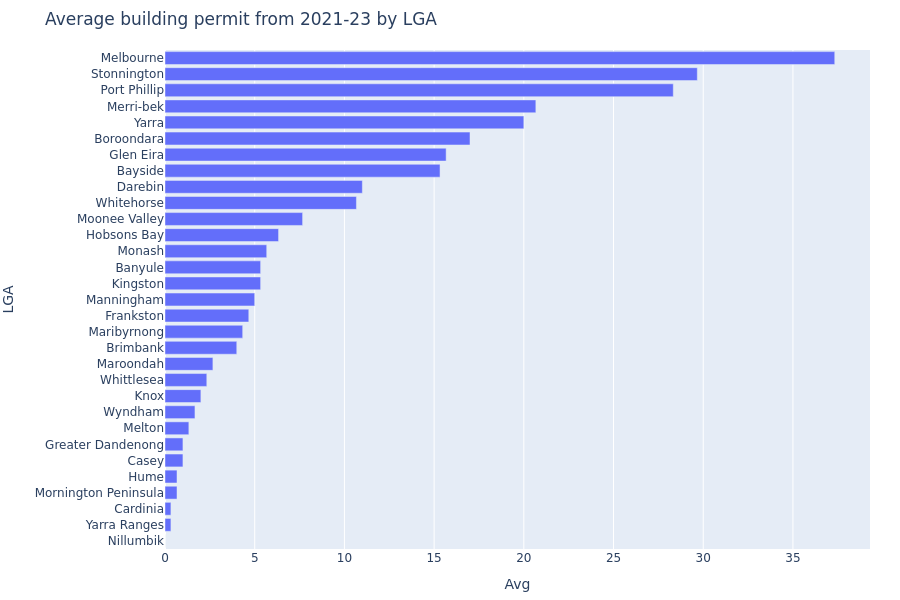

In [88]:
# Average of last three years (2024 isn't finished so not including)
abp_lga_avg_3_yrs = abp_lga_counts[[2021, 2022, 2023]].mean(axis=1).to_frame().reset_index()
abp_lga_avg_3_yrs.columns = ['LGA', 'Avg']
abp_lga_avg_3_yrs['Avg'] = round(abp_lga_avg_3_yrs['Avg'],2)
abp_lga_avg_3_yrs = abp_lga_avg_3_yrs.sort_values(by='Avg', ascending=True)
fig = px.bar(abp_lga_avg_3_yrs, y='LGA', x='Avg', width=900, height=600,
             title='Average building permit from 2021-23 by LGA')

fig.update_layout(
    margin={'t':50,'l':80,'b':10,'r':30},
    showlegend=False
)

fig.show(renderer)

In [91]:
abp_lga_counts['sum'] = abp_lga_counts.sum(axis=1)
abp_lga_counts = abp_lga_counts.sort_values(by='sum', ascending=True).drop(columns='sum')
abp_lga_counts_tidy = abp_lga_counts.reset_index().melt(id_vars='site_municipality', var_name='year', value_name='count')
abp_lga_counts_tidy.columns = ['LGA', 'Year', 'Count']

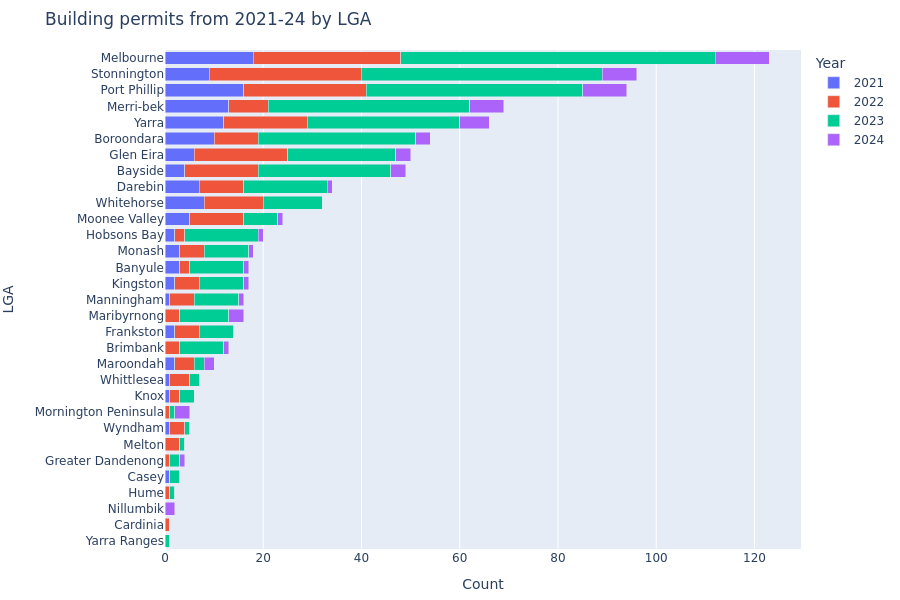

In [103]:
fig = px.bar(abp_lga_counts_tidy, y='LGA', x='Count', color='Year', barmode='stack',
             title='Building permits from 2021-24 by LGA',
             width=900, height=600)

fig.update_layout(
    margin={'t':50,'l':80,'b':10,'r':30}
)

fig.show(renderer)

In [93]:
abp_lga_avg_3_yrs.sort_values('Avg', ascending=False)

,LGA,Avg
17,Melbourne,37.33
25,Stonnington,29.67
24,Port Phillip,28.33
19,Merri-bek,20.67
29,Yarra,20.00
2,Boroondara,17.00
8,Glen Eira,15.67
1,Bayside,15.33
6,Darebin,11.00
26,Whitehorse,10.67


In [96]:
abp_lga_counts

basis_month_y,2021,2022,2023,2024
site_municipality,,,,
Yarra Ranges,0,0,1,0
Cardinia,0,1,0,0
Nillumbik,0,0,0,2
Hume,0,1,1,0
Casey,1,0,2,0
Greater Dandenong,0,1,2,1
Melton,0,3,1,0
Wyndham,1,3,1,0
Mornington Peninsula,0,1,1,3
